<a href="https://colab.research.google.com/github/adrenalinovaya/RL/blob/main/04_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install gymnasium pygame -q
!git clone https://github.com/MattChanTK/gym-maze.git
!cd gym-maze && python3 setup.py install


In [6]:
!pip install swig
!pip install "gymnasium[box2d]"
!pip install gymnasium

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376102 sha256=e14cf90bdf06ecc0e7e78c9d5786ff651da5385f5c9be407d8367bcdc3e1d119
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [7]:
import os
import sys
import PIL
import time
import json
import random
import numpy as np
import pandas as pd
import shutil as sh
from glob import glob
from pytz import timezone
from datetime import datetime
from google.colab import drive
from collections import deque
from base64 import b64encode
from matplotlib import pyplot as plt
from IPython.display import display, clear_output, HTML
import seaborn as sns
import gymnasium as gym
from gymnasium.core import Wrapper
import warnings
warnings.filterwarnings('ignore')

In [83]:
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [17]:
TZ = timezone('Europe/Moscow')

Определение путей и директорий

In [18]:
env_dir = '/content/drive/MyDrive/OTUS/'

In [19]:
scenarios_dir = os.path.join(env_dir, 'scenarios')

In [20]:
if not os.path.exists(scenarios_dir):
    os.makedirs(scenarios_dir)

In [21]:
def display_state(state):
    plt.figure(figsize=(6, 6))
    plt.imshow(state)
    plt.axis('off')


def record_episode(eps_frames, records_dir, agent_name, exp_id, eps_num):
    record_path = os.path.join(records_dir, f'{agent_name}_{exp_id}_eps-{eps_num}.mp4')
    eps_frame_dir = 'episode_frames'
    os.mkdir(eps_frame_dir)

    for i, frame  in enumerate(eps_frames):
        PIL.Image.fromarray(frame).save(os.path.join(eps_frame_dir, f'frame-{i+1}.png'))

    os.system(f'ffmpeg -r 2 -i {eps_frame_dir}/frame-%1d.png -vcodec libx264 -b 10M -y "{record_path}"');
    sh.rmtree(eps_frame_dir)


def show_episode_records(records_dir):
    record_paths = glob(os.path.join(records_dir, "*.mp4"))
    html_str = ''
    for i, record_path in enumerate(record_paths):
        mp4 = open(record_path, 'rb').read()
        data = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        html_str += f'EPISODE # {i+1}<br><video width=500 controls><source src="{data}" type="video/mp4"></video><br><br>'
    return HTML(html_str)

In [22]:
def create_exp_dirs(scenarios_dir, exp_params):
    dirs = dict()
    dirs['exp'] = os.path.join(scenarios_dir, exp_params["scenario_name"], exp_params["algorithm_name"], exp_params["exp_id"])
    dirs['training'] = os.path.join(dirs['exp'], 'training')
    dirs['evaluation'] = os.path.join(dirs['exp'], 'evaluation')
    os.makedirs(dirs['training'], exist_ok=True)
    os.makedirs(dirs['evaluation'], exist_ok=True)
    return dirs


def save_exp_params(params, exp_dir):
    params_path = os.path.join(exp_dir, 'experiment_params.json')
    with open(params_path, 'w') as f:
        json.dump(params, f)


def save_metrics(metrics, metrics_type, train_eps_dir):
    metrics_path = os.path.join(train_eps_dir, f'{metrics_type}_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)

In [23]:
def display_validation_plot(scenarios_dir, scenario_name, exp_ids):
    fig = plt.figure(figsize=(10, 6))
    earliest_validation_eps = np.inf
    max_training_eps_count = 0

    for model_name in exp_ids.keys():
        for exp_id in exp_ids[model_name]:
            exp_dir = os.path.join(scenarios_dir, scenario_name, model_name, exp_id)
            exp_params_path = os.path.join(exp_dir, 'experiment_params.json')
            training_dir = os.path.join(exp_dir, 'training')

            with open(exp_params_path, 'r') as f:
                exp_params = json.load(f)
            total_eps_count = exp_params['training']['episode_count']
            validation_step = exp_params['validation']['validate_agent_every_n_eps']
            if total_eps_count > max_training_eps_count:
                max_training_eps_count = total_eps_count
            if validation_step < earliest_validation_eps:
                earliest_validation_eps = validation_step

            exp_win_shares = list()
            for iter_name in os.listdir(training_dir):
                iter_metrics_path = os.path.join(training_dir, iter_name, 'training_iter_metrics.json')
                with open(iter_metrics_path, 'r') as f:
                    iter_metrics = json.load(f)
                exp_win_shares.append(iter_metrics['win_share'])

            iter_means = np.mean(exp_win_shares, axis=0).round(3)
            iter_stds = np.std(exp_win_shares, axis=0).round(3)
            std_bounds = np.array([[avg - std, avg + std] for avg, std in list(zip(iter_means, iter_stds))])
            validation_steps = range(validation_step, total_eps_count + validation_step, validation_step)

            plt.plot(validation_steps, iter_means, label=f'{model_name} ({exp_id})')
            plt.fill_between(validation_steps, std_bounds[:,0], std_bounds[:,1], alpha=.3)

    plt.xlim(earliest_validation_eps, max_training_eps_count)
    plt.ylim(0, 1)
    plt.xlabel('Training episodes')
    plt.ylabel('Win share')
    plt.title(f'Сomparative assessment of learning process ({scenario_name})')
    plt.legend(loc='upper left')
    plt.grid()

In [24]:
def load_best_agent_for_train_step(train_eps_num, iteration_count, training_dir, agent):
    best_iter_num = 1
    best_win_share = 0
    best_avg_step_count = 100
    for iter_num in range(1, iteration_count+1):
        iter_dir = os.path.join(training_dir, f'iter-{iter_num}')
        eps_dir = os.path.join(iter_dir, f'eps-{train_eps_num}')
        val_metrics_path = os.path.join(eps_dir, 'validation_metrics.json')
        with open(val_metrics_path, 'r') as f:
            val_metrics = json.load(f)
        if val_metrics['win_share'] > best_win_share and val_metrics['avg_step_count'] < best_avg_step_count:
            best_iter_num = iter_num
            best_win_share = val_metrics['win_share']
            best_avg_step_count = val_metrics['avg_step_count']

    agent_state_dir = os.path.join(training_dir, f'iter-{best_iter_num}', f'eps-{train_eps_num}')
    agent.load_agent_state(agent_state_dir)

Обзор окружения

In [25]:
MAP_SIZE = 8
STOCHASTIC_ENV = False
ACTION_MAP = {
    'L': 0,
    'D': 1,
    'R': 2,
    'U': 3
}

def create_environment(map_size, stochastic_env):
    return gym.make('FrozenLake-v1', map_name=f'{map_size}x{map_size}', is_slippery=stochastic_env, render_mode='rgb_array')

In [26]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
state, info = env.reset()
state_rgb = env.render()

print(f'Current state: {state}')
display_state(state_rgb)

Current state: 0


In [27]:
action_name = 'D'
action = ACTION_MAP[action_name]

next_state, reward, terminated, truncated, info = env.step(action)
next_state_rgb = env.render()

print(f'Current state: {next_state}\nReward: {reward}\nDone: {terminated, truncated}')
display_state(next_state_rgb)

Current state: 8
Reward: 0.0
Done: (False, False)


In [28]:
env.close()

Тестирование агента со случайной стратегией

In [29]:
class RandomAgent:

  def __init__(self, env, params):
      self._env = env
      self._params = params

  @property
  def name(self):
      return f"{self._params['algorithm_name']}_agent"

  def choose_action(self, state, mode='exploitation'):
      return self._env.action_space.sample()

In [30]:
def run_episode(env, agent):
    state, info = env.reset()
    step_count = 0
    frames = list()
    done = False

    while not done:
        action = agent.choose_action(state, mode='exploitation')
        next_state, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        done = terminated or truncated
        state = next_state
        step_count += 1

    frames.extend([env.render()] * 3)
    return state, step_count, frames


def evaluate_agent(env, agent, exp_params, exp_dirs):
    for eps_num in range(1, exp_params['evaluation']['episode_count'] + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        record_episode(eps_frames, exp_dirs['evaluation'], exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

        print(f'EPISODE # {eps_num}')
        if eps_final_state == env.observation_space.n - 1:
            print('Agent reached the Goal 🏆')
        else:
            print('Agent was defeated ☠️')
        print(f'Number of steps: {eps_step_count}')
        print('-' * 50)

In [31]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'random',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [32]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
random_agent = RandomAgent(env, exp_params)
evaluate_agent(env, random_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 17
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 50
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Number of steps: 10
--------------------------------------------------


In [33]:
show_episode_records(exp_dirs['evaluation'])

Тестирование Q-агента в детерминированной среде

In [34]:
MAP_SIZE = 8
STOCHASTIC_ENV = False

In [35]:
class QAgent:

    def __init__(self, env, params):
        self._env = env
        self._params = params
        self._epsilon = params['training']['epsilon']
        self._qtable = np.zeros((env.observation_space.n, env.action_space.n))
        self._action_arrow_map = { 0: '', 1: '←', 2: '↓', 3: '→', 4: '↑' }

    @property
    def name(self):
        return f"{self._params['algorithm_name']}_agent"

    @property
    def exploration_level(self):
        return self._epsilon


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
          if np.random.rand() < self._epsilon:
              return self._env.action_space.sample()

        return np.argmax(self._qtable[state, :])


    def learn(self, state, action, next_state, reward):
        target = reward + self._params['training']['gamma'] * np.max(self._qtable[next_state, :])
        self._qtable[state, action] = self._qtable[state, action] + \
                                      self._params['training']['learning_rate'] * (target - self._qtable[state, action])


    def decrease_exploration_level(self):
        if self._epsilon > self._params['training']['epsilon_min']:
            self._epsilon *= self._params['training']['epsilon_decay_rate']


    def display_q_table(self):
        self._prepare_q_table()


    def save_q_table_as_plot(self, eps_dir):
        q_table_plot = self._prepare_q_table()
        q_table_plot_path = os.path.join(eps_dir, 'qtable.png')
        q_table_plot.savefig(q_table_plot_path, bbox_inches='tight')
        plt.close(q_table_plot)


    def save_agent_state(self, eps_dir):
        qtable_path = os.path.join(eps_dir, 'qtable.npy')
        np.save(qtable_path, self._qtable)


    def load_agent_state(self, eps_dir):
        qtable_path = os.path.join(eps_dir, 'qtable.npy')
        self._qtable = np.load(qtable_path, allow_pickle=True)


    def _prepare_q_table(self):
        greedy_values = np.max(self._qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
        greedy_actions = np.argmax(np.hstack((np.zeros((self._env.observation_space.n, 1)), self._qtable)), axis=1)
        greedy_actions_arrows = np.array(list(map(lambda x: '' if x == 0 else self._action_arrow_map[x], greedy_actions))).reshape(MAP_SIZE, MAP_SIZE)

        fig = plt.figure()
        sns.heatmap(greedy_values,
                    annot=greedy_actions_arrows,
                    annot_kws={"fontsize": 16},
                    fmt = '',
                    cmap="YlGnBu",
                    linewidths=.5)
        plt.axis('off')
        return fig


In [36]:
def train_agent(env, agent, exp_params, exp_dirs, enable_eps_recording):
    random.seed(exp_params['seed'])
    np.random.seed(exp_params['seed'])

    train_iter_count = len(os.listdir(exp_dirs['training']))
    train_iter_dir = os.path.join(exp_dirs['training'], f'iter-{train_iter_count+1}')
    os.mkdir(train_iter_dir)

    training_eps_count = exp_params['training']['episode_count']
    validate_agent_every_n_eps = exp_params['validation']['validate_agent_every_n_eps']
    validation_eps_count = exp_params['validation']['episode_count']

    train_metrics = {
        'total_eps_count': training_eps_count,
        'validation_step': validate_agent_every_n_eps,
        'win_share': []
    }

    for eps_num in range(1, training_eps_count + 1):
        state, info = env.reset()
        done = False

        while not done:
            action = agent.choose_action(state, mode='exploration')
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.learn(state, action, next_state, reward)
            done = terminated or truncated
            state = next_state

        agent.decrease_exploration_level()

        if eps_num % validate_agent_every_n_eps == 0:
            eps_dir = os.path.join(train_iter_dir, f'eps-{eps_num}')
            os.mkdir(eps_dir)

            val_metrics = validate_agent(env, agent, exp_params, eps_dir, enable_eps_recording)
            train_metrics['win_share'].append(val_metrics['win_share'])
            agent.save_q_table_as_plot(eps_dir)
            agent.save_agent_state(eps_dir)

            print(f"EPISODE # {eps_num} / {training_eps_count}")
            print(f"Win share ({validation_eps_count} eps): {val_metrics['win_share']}")
            print(f"Avg step count ({validation_eps_count} eps): {val_metrics['avg_step_count']}")
            print(f"Aget exploration level (epsilon): {val_metrics['exploration_level']}")
            print('-' * 50)

    save_metrics(train_metrics, 'training_iter', train_iter_dir)
    return train_metrics


def validate_agent(env, agent, exp_params, train_eps_dir, enable_eps_recording):
    validation_eps_count = exp_params['validation']['episode_count']
    won_eps_count = 0
    eps_step_counts = list()

    for eps_num in range(1, validation_eps_count + 1):
        eps_final_state, eps_step_count, eps_frames = run_episode(env, agent)
        if eps_final_state == env.observation_space.n - 1:
            won_eps_count += 1
        eps_step_counts.append(eps_step_count)
        if enable_eps_recording:
            record_episode(eps_frames, train_eps_dir, exp_params['algorithm_name'], exp_params['exp_id'], eps_num)

    val_metrics = {
        'win_share': round(won_eps_count / validation_eps_count, 3),
        'avg_step_count': round(sum(eps_step_counts) / validation_eps_count, 3),
        'exploration_level': round(agent.exploration_level, 3)
    }

    save_metrics(val_metrics, 'validation', train_eps_dir)
    return val_metrics

In [37]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'qtable',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 1,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [38]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    qtable_agent = QAgent(env, exp_params)
    train_agent(env, qtable_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 1

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.861
------------------------

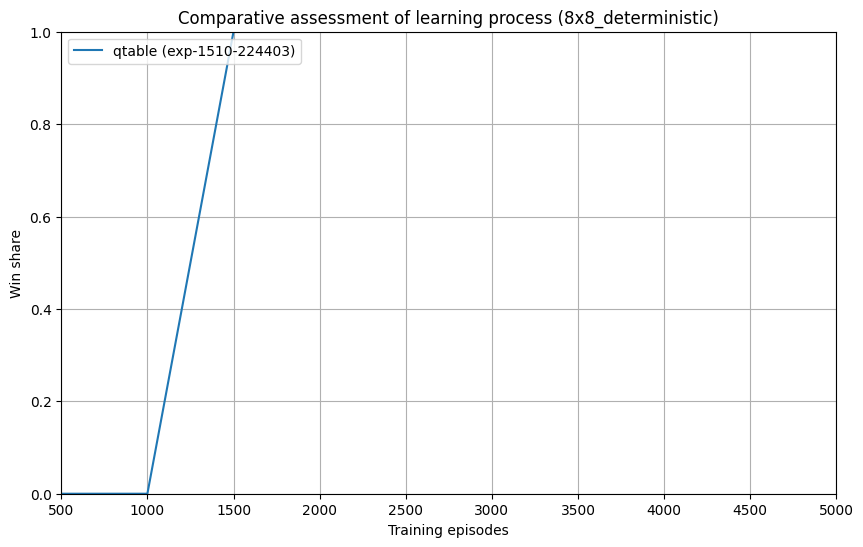

In [39]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

In [40]:
qtable_agent.display_q_table()

In [41]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, qtable_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 2
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------
EPISODE # 3
Agent reached the Goal 🏆
Number of steps: 14
--------------------------------------------------


In [42]:
show_episode_records(exp_dirs['evaluation'])

Тестирование DynaQ-агента в детерминированной среде

In [43]:
MAP_SIZE = 8
STOCHASTIC_ENV = False

In [44]:
class DeterministicEnvModel:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.completed_transitions = set()
        self.transitions = np.zeros((n_states, n_actions), dtype=np.uint8)
        self.rewards = np.zeros((n_states, n_actions), dtype=np.uint8)


    def update(self, state, action, next_state, reward):
        if (state, action) not in self.completed_transitions:
            self.completed_transitions.add((state, action))
            self.transitions[state, action] = next_state
            self.rewards[state, action] = reward


    def sample(self):
        return random.choice(list(self.completed_transitions))


    def step(self, state, action):
        next_state = self.transitions[state, action]
        reward = self.rewards[state, action]
        return next_state, reward


    def display_transitions(self):
        display(HTML(pd.DataFrame(self.transitions, columns=['L', 'D', 'R', 'U']).T.to_html()))


    def display_rewards(self):
        display(HTML(pd.DataFrame(self.rewards, columns=['L', 'D', 'R', 'U']).T.to_html()))

In [45]:
class DynaQAgent:

    def __init__(self, env, env_model_cls, params):
        self._env = env
        self._params = params
        self._epsilon = params['training']['epsilon']
        self._qtable = np.zeros((env.observation_space.n, env.action_space.n))
        self._model = env_model_cls(env.observation_space.n, env.action_space.n)
        self._action_arrow_map = { 0: '', 1: '←', 2: '↓', 3: '→', 4: '↑' }

    @property
    def name(self):
        return f"{self._params['algorithm_name']}_agent"

    @property
    def exploration_level(self):
        return self._epsilon


    def choose_action(self, state, mode='exploitation'):
        if mode == 'exploration':
          if np.random.rand() < self._epsilon:
              return self._env.action_space.sample()

        return np.argmax(self._qtable[state, :])


    def learn(self, state, action, next_state, reward):
        self._learn(state, action, next_state, reward)
        self._update_model(state, action, next_state, reward)
        self._planning(self._params['training']['planning_steps'])


    def decrease_exploration_level(self):
        if self._epsilon > self._params['training']['epsilon_min']:
            self._epsilon *= self._params['training']['epsilon_decay_rate']


    def display_q_table(self):
        self._prepare_q_table()


    def save_q_table_as_plot(self, eps_dir):
        q_table_plot = self._prepare_q_table()
        q_table_plot_path = os.path.join(eps_dir, 'qtable.png')
        q_table_plot.savefig(q_table_plot_path, bbox_inches='tight')
        plt.close(q_table_plot)


    def display_model(self):
        print(f'Transitions tabel:\n')
        self._model.display_transitions()
        print(f'\n\nRewards tabel:\n')
        self._model.display_rewards()


    def save_agent_state(self, state_dir):
        np.save(os.path.join(state_dir, 'qtable.npy'), self._qtable)
        np.save(os.path.join(state_dir, 'model_transitions.npy'), self._model.transitions)
        np.save(os.path.join(state_dir, 'model_rewards.npy'), self._model.rewards)


    def load_agent_state(self, state_dir):
        self._qtable = np.load(os.path.join(state_dir, 'qtable.npy'), allow_pickle=True)
        self._model.transitions = np.load(os.path.join(state_dir, 'model_transitions.npy'), allow_pickle=True)
        self._model.rewards = np.load(os.path.join(state_dir, 'model_rewards.npy'), allow_pickle=True)


    def _learn(self, state, action, next_state, reward):
        target = reward + self._params['training']['gamma'] * np.max(self._qtable[next_state, :])
        self._qtable[state, action] = self._qtable[state, action] + \
                                      self._params['training']['learning_rate'] * (target - self._qtable[state, action])


    def _update_model(self, state, action, next_state, reward):
        self._model.update(state, action, next_state, reward)


    def _planning(self, n_steps):
        for i in range(n_steps):
            state, action =  self._model.sample()
            next_state, reward = self._model.step(state, action)
            self._learn(state, action, next_state, reward)


    def _prepare_q_table(self):
        greedy_values = np.max(self._qtable, axis=1).reshape(MAP_SIZE, MAP_SIZE)
        greedy_actions = np.argmax(np.hstack((np.zeros((self._env.observation_space.n, 1)), self._qtable)), axis=1)
        greedy_actions_arrows = np.array(list(map(lambda x: '' if x == 0 else self._action_arrow_map[x], greedy_actions))).reshape(MAP_SIZE, MAP_SIZE)

        fig = plt.figure()
        sns.heatmap(greedy_values,
                    annot=greedy_actions_arrows,
                    annot_kws={"fontsize": 16},
                    fmt = '',
                    cmap="YlGnBu",
                    linewidths=.5)
        plt.axis('off')
        return fig

In [46]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'dynaq',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 1,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995,
        'planning_steps': 30
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [47]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    dynaq_agent = DynaQAgent(env, DeterministicEnvModel, exp_params)
    train_agent(env, dynaq_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 1

EPISODE # 500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 1.0
Avg step count (10 eps): 14.0
Aget exploration level (epsilon): 0.861
--------------------------

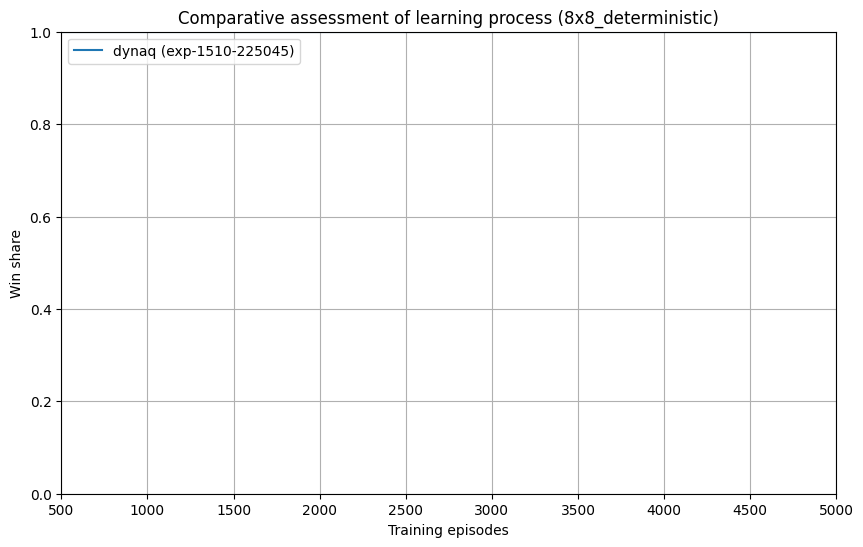

In [54]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

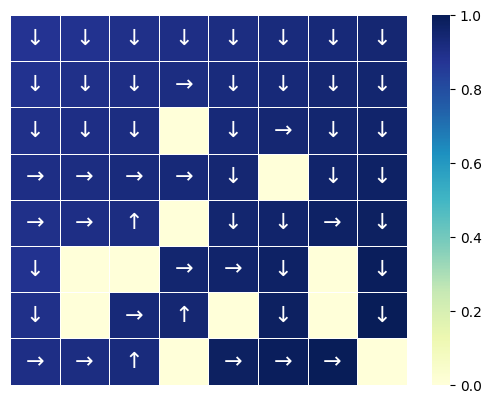

In [55]:
dynaq_agent.display_q_table()

In [56]:
dynaq_agent.display_model()

Transitions tabel:





Rewards tabel:



In [57]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, dynaq_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 12
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 14
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Number of steps: 21
--------------------------------------------------


In [58]:
show_episode_records(exp_dirs['evaluation'])

Тестирование Q-агента в стохастической среде

In [59]:
MAP_SIZE = 8
STOCHASTIC_ENV = True

In [60]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'qtable',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 5,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [61]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    qtable_agent = QAgent(env, exp_params)
    train_agent(env, qtable_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 5

EPISODE # 500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 100.0
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 44.6
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 27.1
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.1
Avg step count (10 eps): 45.3
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 0.6
Avg step count (10 eps): 57.7
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 0.4
Avg step count (10 eps): 59.1
Aget exploration level (epsilon): 0.861
-------------------------

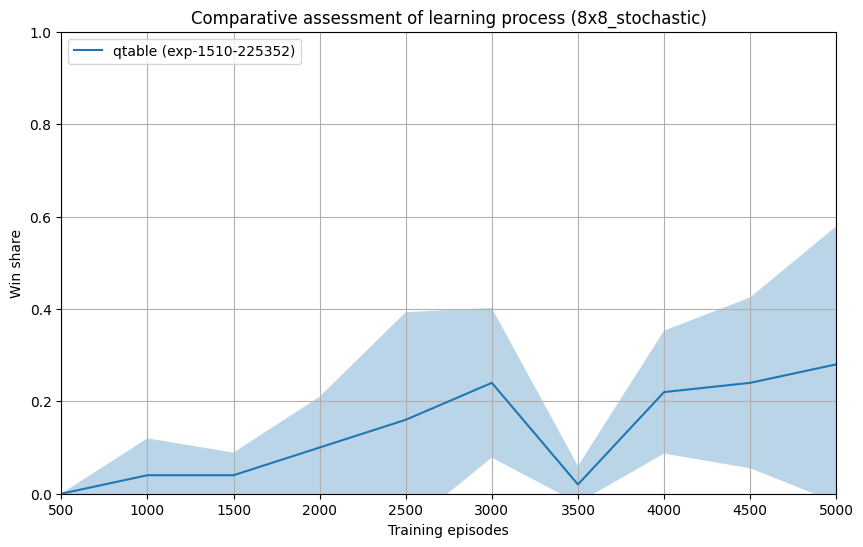

In [62]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

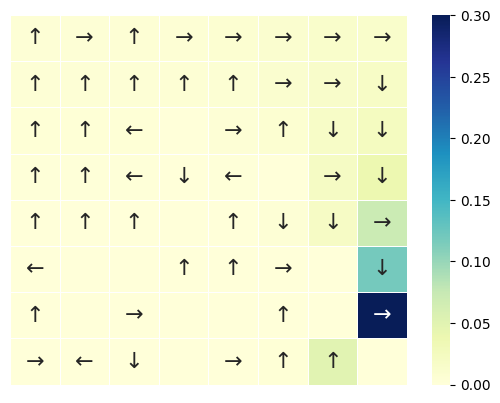

In [63]:
qtable_agent.display_q_table()

In [64]:
train_eps_num = 3500

load_best_agent_for_train_step(train_eps_num,
                               exp_params['training']['iteration_count'],
                               exp_dirs['training'],
                               qtable_agent)

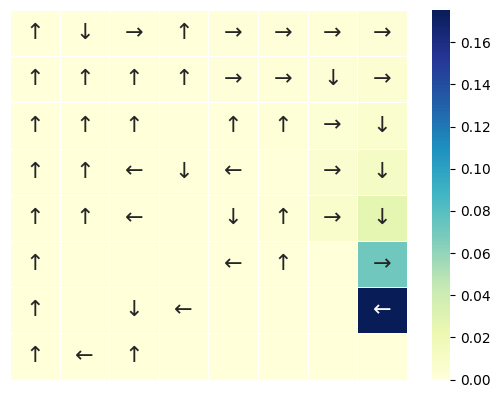

In [65]:
qtable_agent.display_q_table()

In [66]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, qtable_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 63
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 21
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Number of steps: 43
--------------------------------------------------


In [67]:
show_episode_records(exp_dirs['evaluation'])

Тестирование DynaQ-агента в стохастической среде

In [68]:
MAP_SIZE = 8
STOCHASTIC_ENV = True

In [69]:
class StochasticEnvModel:

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.completed_transitions = set()
        self.transitions = np.zeros((n_states, n_actions), dtype=np.uint8)
        self.rewards = np.zeros((n_states, n_actions), dtype=np.uint8)


    def update(self, state, action, next_state, reward):
        if (state, action) not in self.completed_transitions:
            self.completed_transitions.add((state, action))
            self.transitions[state, action] = next_state
            self.rewards[state, action] = reward


    def sample(self):
        return random.choice(list(self.completed_transitions))


    def step(self, state, action):
        next_state = self.transitions[state, action]
        reward = self.rewards[state, action]
        return next_state, reward


    def display_transitions(self):
        display(HTML(pd.DataFrame(self.transitions, columns=['L', 'D', 'R', 'U']).T.to_html()))


    def display_rewards(self):
        display(HTML(pd.DataFrame(self.rewards, columns=['L', 'D', 'R', 'U']).T.to_html()))

In [70]:
exp_params = {
    'scenario_name': f'{MAP_SIZE}x{MAP_SIZE}_{"stochastic" if STOCHASTIC_ENV else "deterministic"}',
    'algorithm_name': 'dynaq',
    'exp_id': f'exp-{datetime.now(TZ).strftime("%d%m-%H%M%S")}',
    'seed': 21,
    'training': {
        'iteration_count': 5,
        'episode_count': 5000,
        'learning_rate': 0.05,
        'gamma': 0.99,
        'epsilon': 1.0,
        'epsilon_min': 0.01,
        'epsilon_decay_rate': 0.99995,
        'planning_steps': 30
    },
    'validation': {
        'validate_agent_every_n_eps': 500,
        'episode_count': 10
    },
    'evaluation': {
        'episode_count': 3
    }
}

exp_dirs = create_exp_dirs(scenarios_dir, exp_params)
save_exp_params(exp_params, exp_dirs['exp'])

In [71]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)

for iter_num in range(1, exp_params['training']['iteration_count']+1):
    print(f'TRAINING ITERATION # {iter_num}\n')
    dynaq_agent = DynaQAgent(env, StochasticEnvModel, exp_params)
    train_agent(env, dynaq_agent, exp_params, exp_dirs, enable_eps_recording=True)
    if iter_num != exp_params['training']['iteration_count']:
        clear_output()

env.close()

TRAINING ITERATION # 5

EPISODE # 500 / 5000
Win share (10 eps): 0.1
Avg step count (10 eps): 27.7
Aget exploration level (epsilon): 0.975
--------------------------------------------------
EPISODE # 1000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 32.0
Aget exploration level (epsilon): 0.951
--------------------------------------------------
EPISODE # 1500 / 5000
Win share (10 eps): 0.1
Avg step count (10 eps): 53.9
Aget exploration level (epsilon): 0.928
--------------------------------------------------
EPISODE # 2000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 22.2
Aget exploration level (epsilon): 0.905
--------------------------------------------------
EPISODE # 2500 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 31.9
Aget exploration level (epsilon): 0.882
--------------------------------------------------
EPISODE # 3000 / 5000
Win share (10 eps): 0.0
Avg step count (10 eps): 24.9
Aget exploration level (epsilon): 0.861
--------------------------

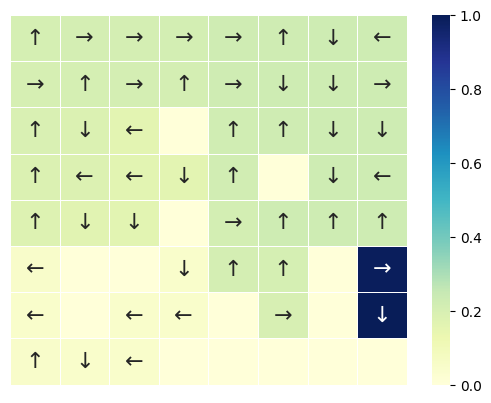

In [72]:
dynaq_agent.display_q_table()

In [73]:
dynaq_agent.display_model()

Transitions tabel:





Rewards tabel:



In [74]:
scenario_name = exp_params['scenario_name']
exp_ids = {
    exp_params['algorithm_name']: [exp_params['exp_id']]
}

display_validation_plot(scenarios_dir, scenario_name, exp_ids)

In [75]:
train_eps_num = 4000

load_best_agent_for_train_step(train_eps_num,
                               exp_params['training']['iteration_count'],
                               exp_dirs['training'],
                               dynaq_agent)

In [76]:
dynaq_agent.display_q_table()

In [77]:
env = create_environment(map_size=MAP_SIZE, stochastic_env=STOCHASTIC_ENV)
evaluate_agent(env, dynaq_agent, exp_params, exp_dirs)
env.close()

EPISODE # 1
Agent was defeated ☠️
Number of steps: 31
--------------------------------------------------
EPISODE # 2
Agent was defeated ☠️
Number of steps: 100
--------------------------------------------------
EPISODE # 3
Agent was defeated ☠️
Number of steps: 36
--------------------------------------------------


In [78]:
show_episode_records(exp_dirs['evaluation'])